# An Application of Online EM Algorithm to Letter Prediction Problem

The implementation of HMM in large part belongs to Ali Taylan Cemgil(ATC): 
https://github.com/atcemgil/notes/blob/master/HiddenMarkovModel.ipynb

The code importing the data also belongs to ATC: https://github.com/atcemgil/notes/blob/master/Sampling.ipynb

In [1]:
%run 'HMM.ipynb'

LL of the generative model is -206.2796
Results with the Forward Smoother
[[ 0.0019486 ]
 [ 0.02140168]
 [ 0.97664971]]
1.0


[[ 24.99759584   0.34982479   7.82727872]
 [  2.65628837   8.04693052   1.08826396]
 [  5.50077119   3.40618759  45.12685902]]
99.0


[[  5.02086900e+00   1.95220874e+00   2.69222523e-02]
 [  2.41142293e+00   1.20276329e+00   1.38581378e+00]
 [  2.33750342e+00   8.44776800e-01   8.17719785e-01]
 [  9.94134469e-01   3.91013270e-01   2.61485226e+00]
 [  1.55206456e+00   2.01118799e-01   2.62468166e+01]
 [  8.89315122e+00   3.89593629e+00   1.21091249e+00]
 [  2.98171133e+00   2.54260416e+00   4.75684507e-01]
 [  5.55790557e-03   4.20027899e-01   1.05744142e+01]
 [  8.04620670e+00   3.40482852e-01   2.61331044e+00]
 [  9.34026416e-01   2.19524307e-02   9.04402115e+00]]
100.0


Results with the Correction Smoother
[ 0.0019486   0.02140168  0.97664971]
1.0


[[ 24.99759584   0.34982479   7.82727872]
 [  2.65628837   8.04693052   1.08826396]
 [  5.50077119   3.4061875

### HMM to Graph

In [2]:
import networkx as nx
    
'''
graph = [(0, 1), (1, 5), (1, 7), (4, 5), (4, 8), (1, 6), (3, 7), (5, 9),
         (2, 4), (0, 4), (2, 5), (3, 6), (8, 9)]

# you may name your edge labels
edge_labels = map(chr, range(65, 65+len(graph)))
node_labels = map(chr, range(88,98))

draw_graph(graph,node_labels=node_labels,edge_labels=edge_labels)
'''

# most of the credit goes to https://www.udacity.com/wiki/creating-network-graphs-with-python
def draw_graph(graph, node_labels=None, edge_labels=None, graph_layout='shell',
               node_size=4000, node_color='blue', node_alpha=0.3,
               node_text_size=18,
               edge_color='blue', edge_alpha=0.3, edge_tickness=1,
               edge_text_pos=0.3,
               text_font='sans-serif',figsize=(8,8)):
    
    plt.figure(figsize=figsize)

    # create networkx graph
    G=nx.DiGraph()

    # add edges
    for edge in graph:
        G.add_edge(edge[0], edge[1])

    # these are different layouts for the network you may try
    # shell seems to work best
    if graph_layout == 'spring':
        graph_pos=nx.spring_layout(G)
    elif graph_layout == 'spectral':
        graph_pos=nx.spectral_layout(G)
    elif graph_layout == 'random':
        graph_pos=nx.random_layout(G)
    else:
        graph_pos=nx.shell_layout(G)

    # draw graph
    nx.draw_networkx_nodes(G,graph_pos,node_size=node_size, 
                           alpha=node_alpha, node_color=node_color)
    nx.draw_networkx_edges(G,graph_pos,width=edge_tickness,
                           alpha=edge_alpha,edge_color=edge_color)
    
    
    if node_labels is None:
        node_labels = range(G.number_of_nodes())
        node_labels = dict(zip(G.nodes(), node_labels))
    nx.draw_networkx_labels(G, graph_pos,node_labels,font_size=node_text_size,
                            font_family=text_font)
    
    if edge_labels is None:
        edge_labels = range(G.number_of_edges())
        edge_labels = dict(zip(graph, edge_labels))
    nx.draw_networkx_edge_labels(G, graph_pos, edge_labels=edge_labels, 
                                 label_pos=edge_text_pos)
    plt.show()
    
    
def draw_hmm(hmm,thrX=0.2,thrY=0.1,figsize=(8,8)):
    # set node labels
    node_labels_ = {}
    i2a = {k: v for k,v in enumerate(alphabet)}
    for i in range(hmm.B.shape[1]):
        col = hmm.B[:,i]
        # mean = 1.0/len(col)
        # std = np.std(col)
        # neighbors = np.where(col>mean+std)[0]
        neighbors = np.where(col>thrY)[0]
        name = ''
        for n in neighbors:
            name += i2a[n]
        node_labels_[i] = name

    # set edges
    edge_labels_ = {}
    edges = []
    i2a = {k: v for k,v in enumerate(alphabet)}
    for i in range(hmm.A.shape[1]):
        col = hmm.A[:,i]
        # mean = 1.0/len(col)
        # std = np.std(col)
        # neighbors = np.where(col>mean+std)[0]
        neighbors = np.where(col>thrX)[0]
        for n in neighbors:
            edges.append((i,n))
            edge_labels_[(i,n)] = '{:.2f}'.format(col[n])

    draw_graph(edges,node_labels=node_labels_,edge_labels=edge_labels_,figsize=figsize)
    

# Data Sets

### Preprocessing

In [3]:
%matplotlib inline
from collections import defaultdict
from urllib.request import urlopen
import string
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import gridspec

local = "file://"+os.getcwd()+"/data/"
print(local)
# local = 'file:///home/cagatay/hdd/Dropbox/Academic_Stuff/MyGithubRepos/bayesian/data/'
# Turkish
#"ç","ı","ğ","ö","ş","ü",'â'
# German
#"ä","ß","ö","ü"
# French
#"ù","û","ô","â","à","ç","é","è","ê","ë","î","ï","æ"
tr_alphabet = ['•','a','b','c','ç','d','e','f',
                'g','ğ','h','ı','i','j','k','l',
                'm','n','o','ö','p','q','r','s','ş',
                't','u','ü','w','v','x','y','z']
# Union of Frequent letters in French, Turkish, German and English
my_alphabet = ['•','a','â','ä',"à","æ",'b','c','ç','d','e',"é","è","ê","ë",'f',
                'g','ğ','h','ı','i',"î",'ï','j','k','l',
                'm','n','o','œ',"ô",'ö','p','q','r','s','ş',
                't','u','ù',"û",'ü','w','v','x','y','z','ß']
# Only ascii characters
ascii_alphabet = list('•'+string.ascii_lowercase)
# Reduction table from my alphabet to ascii
my2ascii_table = {
    ord('â'):"a",
    ord('ä'):"ae",
    ord("à"):"a",
    ord("æ"):"ae",
    ord('ç'):"c",
    ord("é"):"e",
    ord("è"):"e",
    ord("ê"):"e",
    ord("ë"):"e",
    ord('ğ'):"g",
    ord('ı'):"i",
    ord("î"):"i",
    ord('ï'):"i",
    ord("İ"):'i',
    ord('œ'):"oe",
    ord("ô"):"o",
    ord('ö'):"o",
    ord('ş'):"s",
    ord('ù'):"u",
    ord("û"):"u",
    ord('ü'):"u",
    ord('ß'):"ss"
    }
# Reduction table from my alphabet to frequent letters in turkish text
my2tr_table = {
    ord('â'):"a",
    ord('ä'):"ae",
    ord("à"):"a",
    ord("æ"):"ae",
    ord("é"):"e",
    ord("è"):"e",
    ord("ê"):"e",
    ord("ë"):"e",
    ord("î"):"i",
    ord('ï'):"i",
    ord("İ"):'i',
    ord('œ'):"oe",
    ord("ô"):"o",
    ord('ù'):"u",
    ord("û"):"u",
    ord('ß'):"ss"
    }


def read_data(fpp, alphabet, tab):
    # ignore punctuation and some other characters
    tb = str.maketrans(".\t\n\r ","•••••", '0123456789!©¦„"\'™#$%&()*,-/:;<=>?@§[\\]^£‘_■`{|}~+»’«°…”’“')
    # ignore unicode characters
    tbu = {ord(u"\ufeff"):None,775: None}
    
    full_text = ""
    for line in fpp:
        s = line.decode('utf-8').lower()
        s = s.translate(tb)
        s = s.translate(tbu)
        s = s.translate(tab)
        # full_text += s + "•" # bullet is for new line
        full_text += s 
    
    # convert string to int array
    a2i = {v: k for k,v in enumerate(alphabet)}
    data = np.zeros(len(full_text),dtype='int')
    for i in range(len(full_text)):
        data[i] = a2i[full_text[i]]
    
    return data, full_text


def count_transitions(fpp, alphabet, tab):
    data, full_text = read_data(fpp, alphabet, tab)
    M = len(alphabet)
    
    # Character pairs 
    A2 = np.zeros((M,M))
    for i in range(len(data)-1):
        A2[data[i],data[i+1]] += 1
    return data, A2
    
    
def extract_words(fpp, alphabet, tab):
    data,full_text = read_data(fpp, alphabet, tab)
    raw_words = np.split( data, np.where(data==0)[0]+1 )
    words = []
    for word in raw_words:
        if len(word) > 2:
            words.append(word)
    return data, words


def print_series(vec,alphabet,T=300):
    i2a = {k:v for k,v in enumerate(alphabet)}
    s = ''
    lngth = np.min((len(vec),T))
    for i in range(lngth):
        s += i2a[vec[i]]
    print("{:s}".format(s))

    
files = ['Actors.txt','antoniusandcleopatra.txt', 'au1.txt','au2.txt','hamlet_turkce.txt','hamlet_deutsch.txt', 
         'hamlet_french.txt', 'hamlet.txt','juliuscaesar.txt','othello.txt', 'starwars_4.txt', 'starwars_5.txt']

alphabets = [ascii_alphabet, ascii_alphabet, tr_alphabet, tr_alphabet, tr_alphabet, ascii_alphabet,
             ascii_alphabet, tr_alphabet,ascii_alphabet,ascii_alphabet, ascii_alphabet, ascii_alphabet]
tables = [my2ascii_table, my2ascii_table, my2tr_table, my2tr_table, my2tr_table, my2ascii_table, 
          my2ascii_table, my2tr_table,my2ascii_table,my2ascii_table, my2ascii_table, my2ascii_table]

def read_all_data():
    y_dict = {}
    word_dict = {}
    alphabet_dict = {}
    table_dict = {}

    for i in range(len(files)):
        file_ = files[i]
        alphabet = alphabets[i]
        table = tables[i]
        raw_data = urlopen(local+file_) 
        y, words = extract_words(raw_data, alphabets[i], tables[i]) 
        y_dict[file_] = y
        word_dict[file_] = words
        alphabet_dict[file_] = alphabet
        table_dict[file_] = table
        
    return [y_dict,word_dict,alphabet_dict,table_dict]
    
[y_dict,word_dict,alphabet_dict,table_dict] = read_all_data()
for file_ in files:
    print("{:s} has {:d} characters and {:d} words".format(file_,len(y_dict[file_]),len(word_dict[file_])))
        

file:///home/cagatay/hdd/Dropbox/Academic_Stuff/github_repos/bayesian/data/
Actors.txt has 256114 characters and 43384 words
antoniusandcleopatra.txt has 147080 characters and 25766 words
au1.txt has 688395 characters and 91495 words
au2.txt has 979913 characters and 131477 words
hamlet_turkce.txt has 24008 characters and 3296 words
hamlet_deutsch.txt has 230338 characters and 35698 words
hamlet_french.txt has 322734 characters and 53341 words
hamlet.txt has 179412 characters and 30906 words
juliuscaesar.txt has 124027 characters and 19862 words
othello.txt has 146887 characters and 26317 words
starwars_4.txt has 193603 characters and 32047 words
starwars_5.txt has 162785 characters and 25942 words


### Count and display occurences of letters in text AND SAVING 

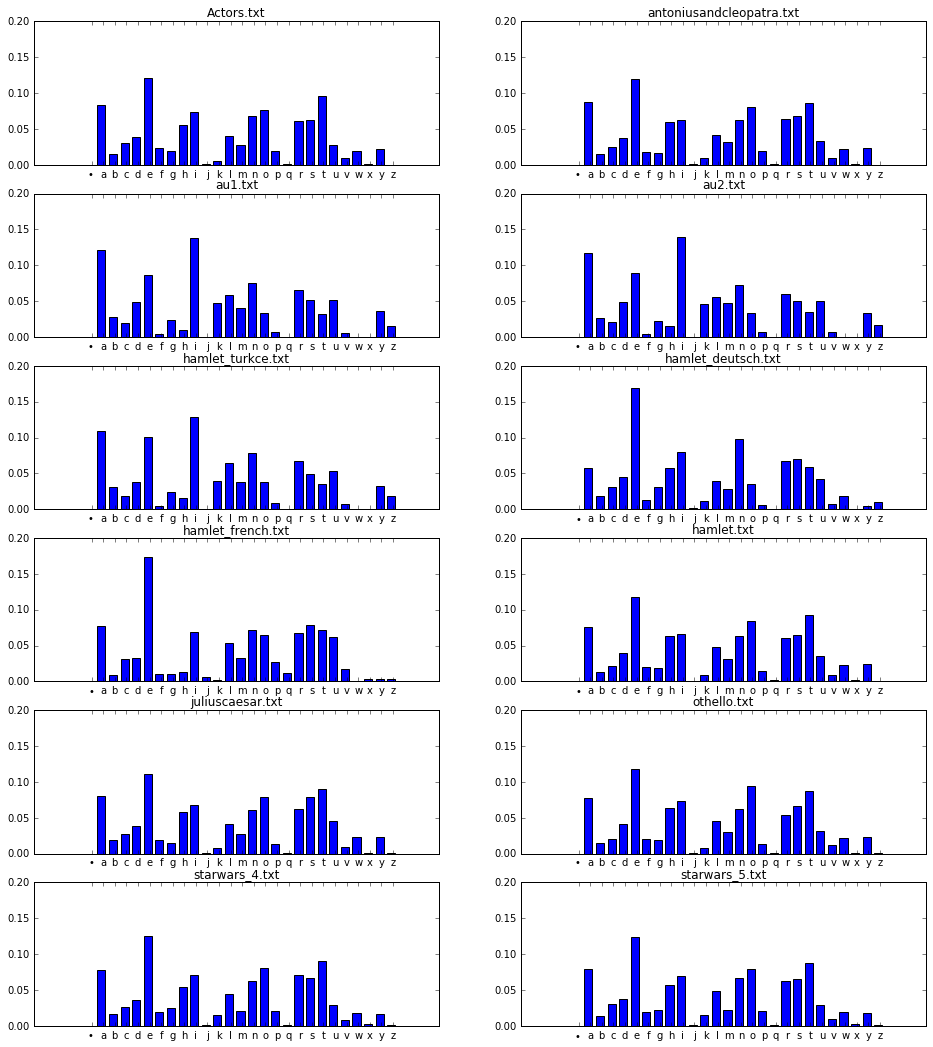

In [4]:
ffiles = ['Actors.txt','antoniusandcleopatra.txt', 'au1.txt','au2.txt','hamlet_turkce.txt','hamlet_deutsch.txt', 
         'hamlet_french.txt', 'hamlet.txt','juliuscaesar.txt','othello.txt', 'starwars_4.txt', 'starwars_5.txt']

plt.figure(figsize=(16,18))

i = 0
for f in files:
    url = local+f
    data = urlopen(url) 
    alphabet = ascii_alphabet
    data, DD = count_transitions(data, ascii_alphabet, my2ascii_table)
    # np.savetxt(f+"_raw", data, delimiter=' ', fmt='%2.0f')   # X is an array
    
    M = len(alphabet)
    # Ignore space, space transitions
    DD[0,0] = 1
    
    i+=1
    plt.subplot(len(files)/2,2,i)
        
    S = np.sum(DD,axis=0)
    #Subpress spaces
    S[0] = 0
    S = S/np.sum(S)

    plt.bar(np.arange(M)-0.5, S, width=0.7)
    plt.xticks(range(M), alphabet)
    plt.gca().set_ylim((0,0.2))
    plt.title(f)

plt.show()




### Counting Bigrams 

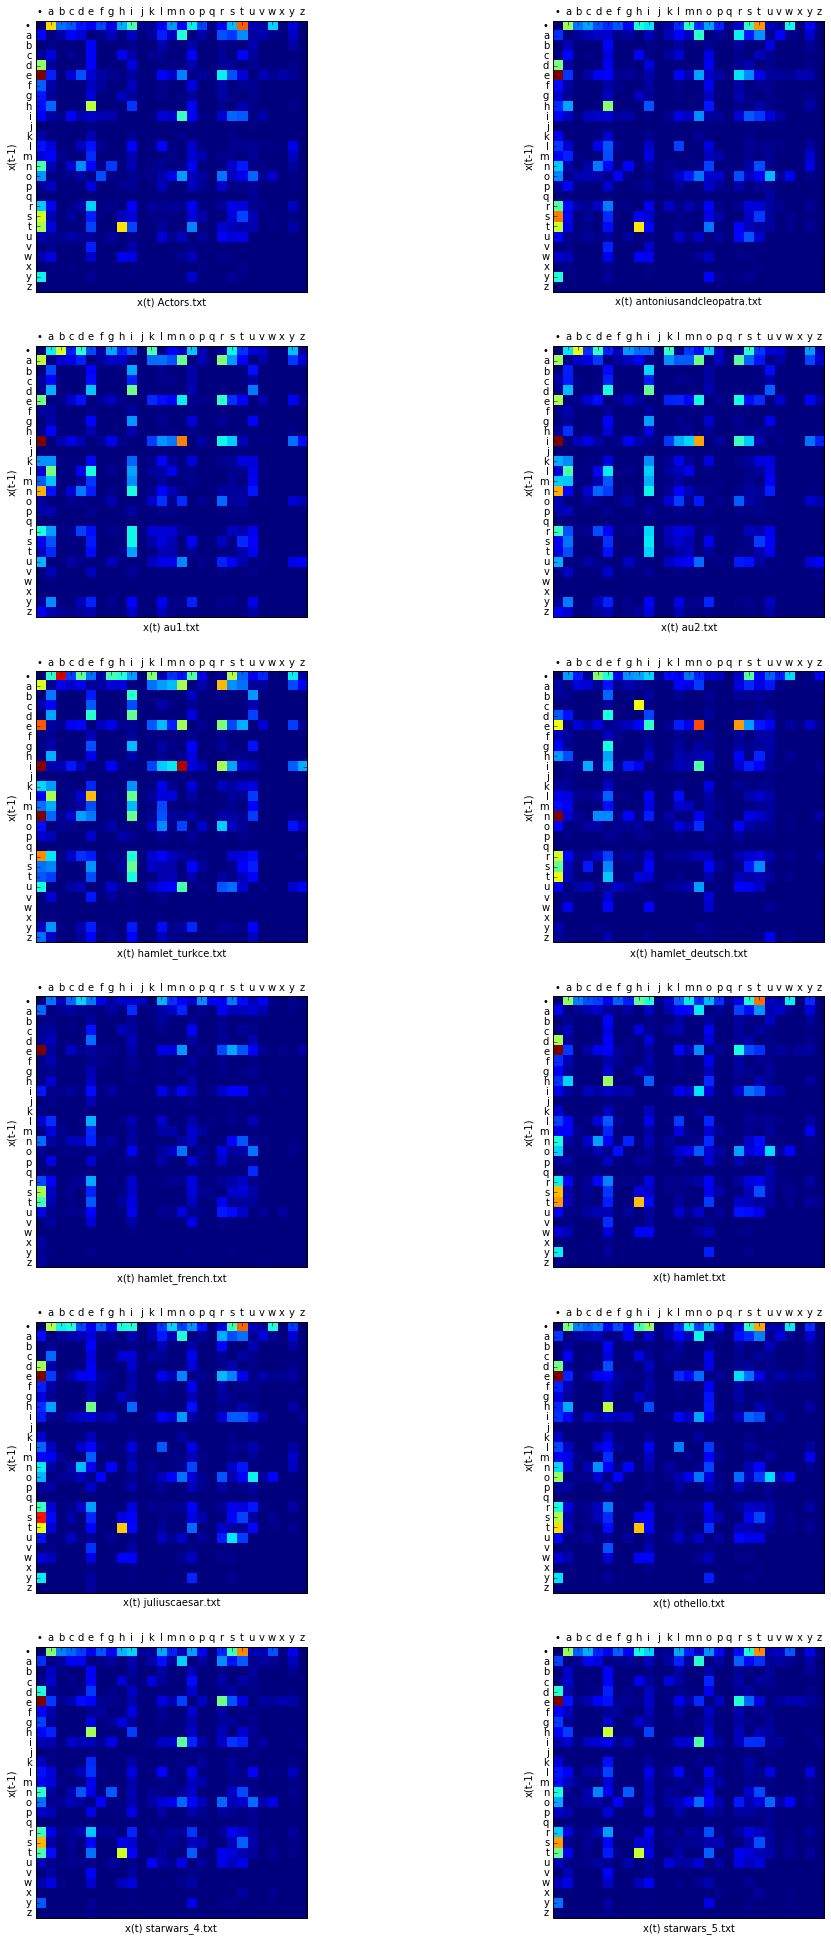

In [5]:
files = ['Actors.txt','antoniusandcleopatra.txt', 'au1.txt','au2.txt','hamlet_turkce.txt','hamlet_deutsch.txt', 
         'hamlet_french.txt', 'hamlet.txt','juliuscaesar.txt','othello.txt', 'starwars_4.txt', 'starwars_5.txt']
plt.figure(figsize=(17,2*17))

i = 0
for f in files:
    url = local+f
    data = urlopen(url)  
    alphabet = ascii_alphabet
    #D, DD, alphabet = count_transitions(data, my_alphabet, {})
    #D, DD, alphabet = count_transitions(data, ascii_alphabet, my2ascii_table)
    data, DD = count_transitions(data, alphabet, my2ascii_table)
    M = len(alphabet)
    DD[0,0] = 1
    
    i+=1
    plt.subplot(len(files)/2,2,i)
    plt.imshow(DD, interpolation='nearest', vmin=0)
    plt.xticks(range(M), alphabet)
    plt.xlabel('x(t)')
    plt.yticks(range(M), alphabet)
    plt.ylabel('x(t-1)')
    ax = plt.gca()
    ax.xaxis.tick_top()
    #ax.set_title(f, va='bottom')
    plt.xlabel('x(t) '+f)

### Parameter Search via C++ Code

In [9]:
import time
from random import shuffle
import subprocess

def normalize(A, axis=0):
    Z = np.sum(A, axis=axis,keepdims=True)
    idx = np.where(Z == 0)
    Z[idx] = 1
    return A/Z

def load_array(filename):
    X = np.loadtxt(filename)
    dim = int(X[0]);
    size = []
    for i in range(dim):
        size.append(int(X[i+1]));    
    X = np.reshape(X[dim+1:], size, order='F')
    return X;
        
def save_array(filename, X, format = '%.6f'):
    with open(filename, 'w') as f:
        dim = len(X.shape)
        f.write('%d\n' % dim)
        for i in range(dim):
            f.write('%d\n' % X.shape[i])
        temp = X.reshape(np.product(X.shape), order='F')
        np.savetxt(f, temp, fmt = format)


def run_em(is_online, data_file_name, hmm_dump_file_name, T=1e5, epoch=100, test_size=1e4, \
           n=100, log_int_=5*1e3, learn_rate_=-0.8, update_freq=1, learning_rate_constant=1):
    main_file_path = "/home/cagatay/workspaces/c++/caca/bin/learn_hmm"
    if not os.path.isfile(main_file_path):
        main_file_path = "/home/cagatay/Desktop/caca/bin/learn_hmm"
    if not os.path.isfile(main_file_path):
        return
    data_file_path = os.getcwd() + "/data/" +  data_file_name + "_raw"
    if is_online:
        command = main_file_path + " -d " + data_file_path + " -h " + hmm_dump_file_name +  " -t " + str(T) + \
                    " -n " + str(n) + " -l " + str(log_int_) + " -p " + str(learn_rate_) + " -u " + str(update_freq) + \
                    " -c " + str(learning_rate_constant)
    else:
        command = main_file_path + " -b -d " + data_file_path + " -h " + hmm_dump_file_name +  " -t " + str(T) + \
                    " -e " + str(epoch) + " -l " + str(test_size)
    print(command)
    proc = subprocess.Popen([command], stdout=subprocess.PIPE, shell=True)
    (out, err)=proc.communicate()
    llhoods_str = str(out).split('\'')[1].replace(' ','').split(',')
    llhoods = [float(ll) for ll in llhoods_str]
    return llhoods
        
files = ['au2.txt','othello.txt','Actors.txt','antoniusandcleopatra.txt', 'au1.txt','hamlet_turkce.txt',
         'hamlet_deutsch.txt','hamlet_french.txt', 'hamlet.txt','juliuscaesar.txt', 'starwars_4.txt', 'starwars_5.txt']

for i in (range(len(files[0:2]))):
    # data preperation
    data_file_name = files[i]
    table = table_dict[data_file_name]
    alphabet = alphabet_dict[data_file_name]
    y = y_dict[data_file_name]
    words = word_dict[data_file_name]
    plt.figure(figsize=(20,50*2))
    
    # init params
    s=5
    r=len(alphabet)
    TR_DATA_LEN = int(10*1e4)
    BATCH_TR_DATA_LEN = TR_DATA_LEN/10
    log_int = int(2*1e3)
    update_freq = 10
    learning_rate_constant = 1e-2
    CONSTRAINED_INIT = False
    hmm_dump_file_name = "hmm.dump"
    
    # init hmms
    hmm = HMM.from_random_parameters(S=s,R=r)
    if CONSTRAINED_INIT:
        hmm = HMM.from_random_parameters_fixed_columns(alphabet,S=s,R=r)
    hmm.dump(filename=hmm_dump_file_name)
    
    batch_lhood = run_em(False,data_file_name, hmm_dump_file_name,T=BATCH_TR_DATA_LEN, test_size=TR_DATA_LEN)
    print("batch_lhood: {:f}".format(batch_lhood[0]))
    
    # HMM.from_random_parameters_fixed_columns(alphabet,S=s,R=r).dump(filename=hmm_dump_file_name)
    
    online_lhoods = []
    learn_rates = []
    for ind in range(4):
    # for ind in range(1,2,1):
        learn_rate = -0.5 - ind*0.2
        lhood = run_em(True,data_file_name, hmm_dump_file_name, T=TR_DATA_LEN, log_int_=log_int, \
                               learn_rate_=learn_rate, update_freq=update_freq, learning_rate_constant=learning_rate_constant)
        print(lhood)
        online_lhoods.append(lhood)
        learn_rates.append(learn_rate)
        # visualization
    
    mx = np.max([batch_lhood[0], np.max(online_lhoods)])*0.9
    mn = np.min(online_lhoods)*1.1
    for ind in range(4):
        online_lhood = online_lhoods[ind]
        plt.subplot(18,2,6*i+1+ind)
        plt.plot(online_lhood,'-*')
        plt.plot(batch_lhood*len(online_lhood),'-*')
        plt.xlabel('observation# * {:d}k'.format(int(log_int/1000)))
        plt.ylabel('loglhood')
        plt.title("{:s},  online em,  {:f}".format(data_file_name,learn_rates[ind]))
        plt.ylim([mn,mx])
        # plt.ylim([-6.5*1e5,-3*1e5])
        
    '''    
    for ind in range(6):
        log_int = 1e4
        [lhoods_5pass_dict, hmm] = run_em(hmm_orig.copy(), tr_data=y[0:TR_DATA_LEN], test_data=y[0:TEST_DATA_LEN], 
                                                 log_int_=log_int, learn_rate_=-0.5-ind*0.1, PASSES = 3)
        HMMs.append(hmm)
        print("online_em_lhoods_5passes-{:f}".format(-0.5-ind*0.1))
        lhoods_5pass = []
        for key in lhoods_5pass_dict: lhoods_5pass.extend(lhoods_5pass_dict[key])
        # visualization
        print(lhoods_5pass_dict)
        plt.subplot(18,2,6*i+7+ind)
        plt.plot(lhoods_5pass,'-*')
        plt.xlabel('observation# x{:d}k'.format(int(log_int/1000)))
        plt.ylabel('loglhood')
        plt.title("{:s}, online em 5pass,  {:f}".format(file_,-0.5-ind*0.1))
    
    
    for ind in range(6):
        log_int = 1e4
        y_conc = []
        for tmp in range(5): y_conc.extend(y[0:TR_DATA_LEN])
        [lhoods_5concat, hmm] = run_em(hmm_orig.copy(), tr_data=y_conc, test_data=y[0:TEST_DATA_LEN],
                                              log_int_=log_int, learn_rate_=-0.5-ind*0.1)
        HMMs.append(hmm)
        print("online_em_lhoods_yyyyy-{:f}".format(-0.5-ind*0.1))
        # visualization
        print(lhoods_5concat[0])
        plt.subplot(18,2,6*i+13+ind)
        plt.plot(lhoods_5concat[0],'-*')
        plt.xlabel('observation# x{:d}k'.format(int(log_int/1000)))
        plt.ylabel('loglhood')
        plt.title("{:s}, online em yyyyy,  {:f}".format(file_,-0.5-ind*0.1))
    '''
    print("\n\n*****\n\n")

None


TypeError: 'NoneType' object is not subscriptable

In [ ]:
# %qtconsole

a =  [[1,7,2,5,6],[42,5,7,5,3]]
mx = np.max([100,np.max(a)])
mn = np.min(a)

plt.plot(online_lhoods,'-*')
plt.plot([7]*len(online_lhoods),'-*')
plt.xlabel('observation# * {:d}k'.format(int(log_int/1000)))
plt.ylabel('loglhood')
plt.ylim([mn,mx])
plt.title("{:s},  online em,  {:f}".format(file_,learn_rate))




### Parameter Search via Python Code

In [7]:
import time
from random import shuffle

def normalize(A, axis=0):
    Z = np.sum(A, axis=axis,keepdims=True)
    idx = np.where(Z == 0)
    Z[idx] = 1
    return A/Z

files=['Actors.txt','au1.txt','starwars_4.txt','hamlet_french.txt','hamlet_turkce.txt','au2.txt','hamlet.txt','Reminiscences_of_Tolstoy.txt']

def run_em(hmm, method=1, tr_data=None, test_data=None, log_int_=5*1e3, learn_rate_=-0.8, PASSES=1, update_freq=1):
    beg = time.time()
    lhoods = {}
    for ep in range(PASSES):
        if method==1:
            LL, params = hmm.online_em(tr_data,log_interval=log_int_,learn_rate=learn_rate_,update_freq=update_freq)
        elif method==2:
            # shuffle(tr_data)
            LL, params = hmm.online_em_c(tr_data,log_interval=log_int_,learn_rate=learn_rate_,update_freq=update_freq)
        elif method==3:
            LL, params = hmm.train_EM(tr_data, EPOCH=10)        
            
        lhoods[ep] = []
        if test_data is None: test_data = tr_data
        for [p,A,B] in params:
            tmp_hmm = HMM(p,A,B)
            log_gamma = tmp_hmm.forward_backward_smoother(test_data)
            lhood = log_sum_exp(log_gamma[:,0])[0]
            lhoods[ep].append(lhood)
    end = time.time()
    return [lhoods, hmm]



HMMs = []

for i in range(len(files[0:2])):
    # data preperation
    file_ = files[i]
    table = table_dict[file_]
    alphabet = alphabet_dict[file_]
    y = y_dict[file_]
    words = word_dict[file_]
    plt.figure(figsize=(15,15*3))
    
    # init params
    s=5
    r=len(alphabet)
    TR_DATA_LEN = 5*1e4
    TEST_DATA_LEN = 5*1e4
    CONSTRAINED_INIT = False
    
    # init hmms
    hmm_orig = HMM.from_random_parameters(S=s,R=r)
    if CONSTRAINED_INIT:
        hmm_orig = HMM.from_random_parameters_fixed_columns(alphabet,S=s,R=r)
    
    # for ind in range(6):
    for ind in range(1,2,1):
        log_int = 5*1e3
        learn_rate = -1 # -0.5-ind*0.1
        [lhoods, hmm] = run_em(hmm_orig.copy(), tr_data=y[0:TR_DATA_LEN], 
                                      test_data=y[0:TEST_DATA_LEN], log_int_=log_int, learn_rate_=learn_rate, update_freq=5)
        HMMs.append(hmm)
        print("online_em_lhoods-{:f}".format(learn_rate))
        # visualization
        print(lhoods)
        plt.subplot(18,2,6*i+1+ind)
        plt.plot(lhoods[0],'-*')
        plt.xlabel('observation# x{:d}k'.format(int(log_int/1000)))
        plt.ylabel('loglhood')
        plt.title("{:s},  online em,  {:f}".format(file_,learn_rate))
        
    '''    
    for ind in range(6):
        log_int = 1e4
        [lhoods_5pass_dict, hmm] = run_em(hmm_orig.copy(), tr_data=y[0:TR_DATA_LEN], test_data=y[0:TEST_DATA_LEN], 
                                                 log_int_=log_int, learn_rate_=-0.5-ind*0.1, PASSES = 3)
        HMMs.append(hmm)
        print("online_em_lhoods_5passes-{:f}".format(-0.5-ind*0.1))
        lhoods_5pass = []
        for key in lhoods_5pass_dict: lhoods_5pass.extend(lhoods_5pass_dict[key])
        # visualization
        print(lhoods_5pass_dict)
        plt.subplot(18,2,6*i+7+ind)
        plt.plot(lhoods_5pass,'-*')
        plt.xlabel('observation# x{:d}k'.format(int(log_int/1000)))
        plt.ylabel('loglhood')
        plt.title("{:s}, online em 5pass,  {:f}".format(file_,-0.5-ind*0.1))
    
    
    for ind in range(6):
        log_int = 1e4
        y_conc = []
        for tmp in range(5): y_conc.extend(y[0:TR_DATA_LEN])
        [lhoods_5concat, hmm] = run_em(hmm_orig.copy(), tr_data=y_conc, test_data=y[0:TEST_DATA_LEN],
                                              log_int_=log_int, learn_rate_=-0.5-ind*0.1)
        HMMs.append(hmm)
        print("online_em_lhoods_yyyyy-{:f}".format(-0.5-ind*0.1))
        # visualization
        print(lhoods_5concat[0])
        plt.subplot(18,2,6*i+13+ind)
        plt.plot(lhoods_5concat[0],'-*')
        plt.xlabel('observation# x{:d}k'.format(int(log_int/1000)))
        plt.ylabel('loglhood')
        plt.title("{:s}, online em yyyyy,  {:f}".format(file_,-0.5-ind*0.1))
    '''
    print("\n\n*****\n\n")
    

TypeError: slice indices must be integers or None or have an __index__ method

### Model Comparisons

In [ ]:
import time
from random import shuffle

def normalize(A, axis=0):
    Z = np.sum(A, axis=axis,keepdims=True)
    idx = np.where(Z == 0)
    Z[idx] = 1
    return A/Z

files=['Actors.txt','au1.txt','starwars_4.txt','hamlet_french.txt','au2.txt','hamlet.txt','Reminiscences_of_Tolstoy.txt','hamlet_turkce.txt']

def run_em(hmm, method=1, tr_data=None, test_data=None, log_int_=5*1e3, learn_rate_=-0.8, PASSES=1):
    beg = time.time()
    lhoods = {}
    for ep in range(PASSES):
        if method==1:
            LL, params = hmm.online_em(tr_data,log_interval=log_int_,learn_rate=learn_rate_)
        elif method==2:
            # shuffle(tr_data)
            LL, params = hmm.online_em_c(tr_data,log_interval=log_int_,learn_rate=learn_rate_)
        elif method==3:
            LL, params = hmm.train_EM(tr_data, EPOCH=10)        
            
        lhoods[ep] = []
        if test_data is None: test_data = tr_data
        for [p,A,B] in params:
            tmp_hmm = HMM(p,A,B)
            log_gamma = tmp_hmm.forward_backward_smoother(test_data)
            lhood = log_sum_exp(log_gamma[:,0])[0]
            lhoods[ep].append(lhood)
    end = time.time()
    return [lhoods, hmm]
    

HMMs = []

for i in range(len(files[0:6])):
    # data preperation
    file_ = files[i]
    table = table_dict[file_]
    alphabet = alphabet_dict[file_]
    y = y_dict[file_]
    words = word_dict[file_]
    plt.figure(figsize=(15,15*3))
    
    # init params
    s=5
    r=len(alphabet)
    TR_DATA_LEN = 2*1e4
    TEST_DATA_LEN = 2*1e4
    BATCH_EM_TR_DATA_LEN = 1e3
    CONSTRAINED_INIT = False
    
    ONLINE = True
    ONLINE_TRAIN_WITH_WORDS = True
    BATCH = True
    
    # init hmms
    hmm_orig = HMM.from_random_parameters(S=s,R=r)
    if CONSTRAINED_INIT:
        hmm_orig = HMM.from_random_parameters_fixed_columns(alphabet,S=s,R=r)
    
    # run hmms
    if ONLINE:
        log_int = 1e4
        [lhoods, hmm] = run_em(hmm_orig.copy(), method=1, 
                               tr_data=y[0:TR_DATA_LEN], test_data=y[0:TEST_DATA_LEN], log_int_=log_int, learn_rate_=-0.91)
        HMMs.append(hmm)
        print("online_em_lhoods")
        # visualization
        print(lhoods)
        plt.subplot(len(files),3,3*i+1)
        plt.plot(lhoods[0],'-*')
        plt.xlabel('observation# x{:d}k'.format(int(log_int/1000)))
        plt.ylabel('loglhood')
        plt.title("{:s} - online em".format(file_))
        
    if ONLINE_TRAIN_WITH_WORDS:
        selected_words = []
        seq_len = 0
        ind=0
        while seq_len < TR_DATA_LEN:
            selected_words.append(words[ind])
            seq_len += len(words[ind]) + 1
            ind += 1
        
        log_int = 2*1e3
        [lhoods_w, hmm] = run_em(hmm_orig.copy(), method=2, 
                                 tr_data=selected_words, test_data=y[0:TEST_DATA_LEN], log_int_=log_int, learn_rate_=-0.51)
        HMMs.append(hmm)
        print("online_em_lhoods trained with words")
        # visualization
        print(lhoods_w)
        plt.subplot(len(files),3,3*i+2)
        plt.plot(lhoods_w[0],'-*')
        plt.xlabel('observation# x{:d}k'.format(int(log_int/1000)))
        plt.ylabel('loglhood')
        plt.title("{:s} - online em trained with words".format(file_))
        
    if BATCH:
        [lhoods_batch_em, hmm] = run_em(hmm_orig.copy(), method=3, tr_data=y[0:BATCH_EM_TR_DATA_LEN], test_data=y[0:TEST_DATA_LEN])
        HMMs.append(hmm)
        print("em_lhoods")
        # visualization
        print(lhoods_batch_em)
        plt.subplot(len(files),3,3*i+3)
        plt.plot(lhoods_batch_em[0],'-*')
        plt.xlabel('epoch #')
        plt.ylabel('loglhood')
        plt.title("{:s} - batch em".format(file_))
    
    
    '''
    # visualization
    plt.subplot(len(files),2,2*i+1)
    plt.imshow(hmm.B, interpolation='nearest', vmin=0)
    plt.colorbar()
    plt.title(file_, y=1.04)
    plt.xticks(range(s))
    plt.yticks(range(len(alphabet)), alphabet)
    plt.gca().xaxis.tick_top()
    plt.xlabel('x(t)')
    plt.ylabel('y(t)')
    
    plt.subplot(len(files),2,2*i+2)
    plt.imshow(hmm.A, interpolation='nearest', vmin=0)
    plt.title(file_, y=1.06)
    plt.xticks(range(s))
    plt.yticks(range(s))
    plt.gca().xaxis.tick_top()
    plt.xlabel('x(t-1)')
    plt.ylabel('x(t)')
    
    draw_hmm(hmm)
    '''
    print("\n\n*****\n\n")
    

### Word by Word Training

In [ ]:
import time

files=['au1.txt','starwars_4.txt','hamlet_french.txt','hamlet_turkce.txt','au1.txt', 'hamlet.txt','Actors.txt','Reminiscences_of_Tolstoy.txt']
alphabets = [tr_alphabet,ascii_alphabet,ascii_alphabet,tr_alphabet,tr_alphabet,ascii_alphabet,ascii_alphabet,ascii_alphabet]
tables = [my2tr_table,my2ascii_table,my2ascii_table,my2tr_table,my2tr_table,my2ascii_table,my2ascii_table,my2ascii_table]

try:
    PASSES
except NameError:
    PASSES = 1

for i in range(len(files[0:1])):
    # data preperation
    table = tables[i]
    alphabet = alphabets[i]
    file_ = files[i]
    raw_data = urlopen(local+file_) 
    data, words = extract_words(raw_data, alphabets[i], tables[i]) 
    
    plt.figure(figsize=(15,15*len(files)))
    for ind in range(1):
        print_series(words[np.random.randint(len(words))],alphabet)
    
    # online em
    s = 5
    r = len(alphabet)
    beg = time.time()
    hmm = HMM.from_random_parameters(S=s,R=r)
    # hmm = HMM.from_random_parameters_fixed_columns(alphabet,S=s,R=r)
    for ep in range(PASSES):
        LL, params = hmm.online_em_c(words[0:50000])
    # LL, params = hmm.online_em(gen_random_subset(1e5))
    '''
    # likelihood calculation at each 1e4'th observation
    for [p,A,B] in params:
        tmp_hmm = HMM(p,A,B)
        log_gamma = tmp_hmm.forward_backward_smoother(proc_data[0:1e5])
        # log_gamma = tmp_hmm.forward_backward_smoother(gen_random_subset(1e5))
        print ("online_em_lhood=%(lh).4f" % {'lh':log_sum_exp(log_gamma[:,0])[0]})
    '''
    end = time.time()
    log_gamma = hmm.forward_backward_smoother(data[0:5*1e4])
    print ("online_em_lhood=%(lh).4f, duration=%(dur).4f" % {'lh':log_sum_exp(log_gamma[:,0])[0],'dur':end-beg})

    '''
    # visualization
    plt.subplot(len(files),2,2*i+1)
    plt.imshow(hmm.B, interpolation='nearest', vmin=0)
    plt.colorbar()
    plt.title(file_, y=1.04)
    plt.xticks(range(s))
    plt.yticks(range(len(alphabet)), alphabet)
    plt.gca().xaxis.tick_top()
    plt.xlabel('x(t)')
    plt.ylabel('y(t)')
    
    plt.subplot(len(files),2,2*i+2)
    plt.imshow(hmm.A, interpolation='nearest', vmin=0)
    plt.title(file_, y=1.06)
    plt.xticks(range(s))
    plt.yticks(range(s))
    plt.gca().xaxis.tick_top()
    plt.xlabel('x(t-1)')
    plt.ylabel('x(t)')
    
    draw_hmm(hmm)
    
    print("\n\n*****\n\n")
    '''

In [ ]:
plt.figure(figsize=(20,10*len(files)))

if ONLINE:
    log_int = 1e4
    print("online_em_lhoods")
    # visualization
    print(lhoods)
    plt.subplot(len(files),2,2*i+1)
    plt.plot(lhoods[0],'-*')
    plt.xlabel('observation #')
    # plt.xticks(range(0,len(lhoods[0]),int(len(lhoods[0])/10)),range(0,int(DATA_LEN),int(DATA_LEN/10)))
    plt.ylabel('lhood')
    plt.title("{:s} - online em".format(file_))

if ONLINE_TRAIN_WITH_WORDS:
    log_int = 1e3
    print("online_em_lhoods trained with words")
    # visualization
    print(lhoods_w)
    plt.subplot(len(files),2,2*i+2)
    plt.plot(lhoods_w[0],'-*')
    plt.xlabel('observation #')
    # plt.xticks(range(0,len(lhoods_w[0]),int(len(lhoods_w[0])/10)),range(0,len(selected_words),int(len(selected_words)/10)))
    plt.ylabel('lhood')
    plt.title("{:s} - online em trained with words".format(file_))

In [ ]:
'''
%qtconsole
%connect_info
a = np.eye(5).reshape((5,1,5))
a[:,0,0] = np.ones(5)
tmp = np.random.random((5,5,5))
print(a)
print(tmp)

print(a*tmp)
print("\n")
print(a[0,:,:]*tmp[0,:,:])
'''

'''
daha uzun datasetler
em'de her epoch'tan sonra likelihood hesaplamaca
'''
%qtconsole


In [ ]:
%qtconsole

online em ve hmm'i eszamanli calistir
data'yi yer yer sil ve interpolate etmeye calis
hmm'in orijinal parametreleriyle online em'i başlat
p(y_t|y_{1:t-1})